In [2]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.metrics import f1_score, accuracy_score, make_scorer, roc_curve, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
breastFileNames = []
breastCount = 0
for filename in glob.glob('data/Breast Invasive Carcinoma/**/*quantification.txt', recursive = True):
    breastFileNames.append(filename)
    breastCount += 1

In [4]:
kidneyFileNames = []
kidneyCount = 0
for filename in glob.glob('data/Kidney Renal Clear Cell Carcinoma/**/*quantification.txt', recursive = True):
    kidneyFileNames.append(filename)
    kidneyCount += 1

In [5]:
lungAdenFileNames = []
lungAdenCount = 0
for filename in glob.glob('data/Lung Adenocarcinoma/**/*quantification.txt', recursive = True):
    lungAdenFileNames.append(filename)
    lungAdenCount += 1

In [6]:
lungSquaFileNames = []
lungSquaCount = 0
for filename in glob.glob('data/Lung Squamous Cell Carcinoma/**/*quantification.txt', recursive = True):
    lungSquaFileNames.append(filename)
    lungSquaCount += 1

In [7]:
panFileNames = []
panCount = 0
for filename in glob.glob('data/Pancreatic Adenocarcinoma/**/*quantification.txt', recursive = True):
    panFileNames.append(filename)
    panCount += 1

In [8]:
uveFileNames = []
uveCount = 0
for filename in glob.glob('data/Uveal Melanoma/**/*quantification.txt', recursive = True):
    uveFileNames.append(filename)
    uveCount += 1

In [9]:
breastFileNames[0]

'data/Breast Invasive Carcinoma/00100f1e-f293-481d-8189-285eaf73dfc2/02ac46fc-c8fe-4604-bb3c-68b3843ebd0e.mirbase21.mirnas.quantification.txt'

In [10]:
def make_feature_set(fileNames):
    df = pd.read_csv(fileNames[0], sep = '\t')
    features = np.empty([1, df['miRNA_ID'].shape[0]])
    for i in range(len(fileNames)):
        df = pd.read_csv(fileNames[i], sep = '\t')
        features = np.vstack([features, df['reads_per_million_miRNA_mapped']])
    
    return features[1:, :]

In [11]:
breastFeatures = make_feature_set(breastFileNames)
kidneyFeatures = make_feature_set(kidneyFileNames)
lungAdenFeatures = make_feature_set(lungAdenFileNames)
lungSquaFeatures = make_feature_set(lungSquaFileNames)
panFeatures = make_feature_set(panFileNames)
uveFeatures = make_feature_set(uveFileNames)

In [12]:
print("Brest Features", breastFeatures.shape)
print("Kidney Features", kidneyFeatures.shape)
print("lung Aden Features", lungAdenFeatures.shape)
print("lung Squa Features", lungSquaFeatures.shape)
print("Pan Features", panFeatures.shape)
print("UVE Features", uveFeatures.shape)

Brest Features (1096, 1881)
Kidney Features (544, 1881)
lung Aden Features (519, 1881)
lung Squa Features (478, 1881)
Pan Features (178, 1881)
UVE Features (80, 1881)


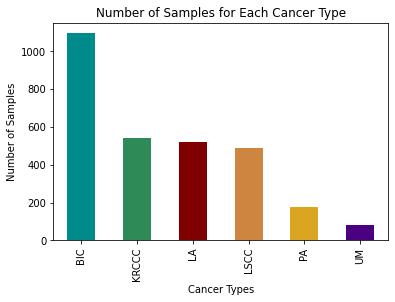

In [13]:
newBreastCol = [[0]] * (len(breastFileNames))
newKidneyCol = [[1]] * (len(kidneyFileNames))
newLungAdenCol = [[2]] * (len(lungAdenFileNames))
newLungSquaCol = [[3]] * (len(lungSquaFileNames))
newPanCol = [[4]] * (len(panFileNames))
newUveCol = [[5]] * (len(uveFileNames))
y_data = np.concatenate((newBreastCol, newKidneyCol, newLungAdenCol, newLungSquaCol, newPanCol, newUveCol))
y_data = pd.DataFrame(y_data)


lbl = ['BIC', 'KRC', 'LAC', 'LSC', 'PAC', 'UMC']
count = [1096, 544, 519, 487, 178, 80]
s = pd.Series(
    [1096, 544, 519, 487, 178, 80],
    index = ['BIC', 'KRCCC', 'LA', 'LSCC', 'PA', 'UM']
)
#df = pd.DataFrame({'label':lbl, 'count':count})
#sns.countplot(y_data.value_counts())

#y_pos = np.arange(len(lbl))

plt.title("Number of Samples for Each Cancer Type")
plt.ylabel('Number of Samples')
plt.xlabel('Cancer Types')

ax = plt.gca()
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

#plt.bar(y_pos, count, align='center', alpha=0.5)
#plt.xticks(y_pos, lbl)
#plt.ylabel('Count')
#plt.title('Lables Count')


s.plot(
    kind='bar', 
    color = ["darkcyan","seagreen", "maroon", "peru", "goldenrod", "indigo"],
)

plt.savefig('CancerCount.png', bbox_inches='tight')
plt.show()

In [13]:
breastFeatures = np.append(breastFeatures, newBreastCol, axis = 1)
kidneyFeatures = np.append(kidneyFeatures, newKidneyCol, axis = 1)
lungAdenFeatures = np.append(lungAdenFeatures, newLungAdenCol, axis = 1)
lungSquaFeatures = np.append(lungSquaFeatures, newLungSquaCol, axis = 1)
panFeatures = np.append(panFeatures, newPanCol, axis = 1)
uveFeatures = np.append(uveFeatures, newUveCol, axis = 1)

In [14]:
features = np.concatenate((breastFeatures, kidneyFeatures, lungAdenFeatures, lungSquaFeatures, panFeatures, uveFeatures))

In [15]:
features.shape

(2895, 1882)

In [16]:
df = pd.read_csv(breastFileNames[0], sep = '\t')
headers = df['miRNA_ID'].to_list() + ['Targets']

featuresDF = pd.DataFrame(features, columns = headers)

In [17]:
featuresDF.head()

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,Targets
0,17225.641202,17168.697999,17165.904559,37132.340301,4217.020216,410.420821,1099.541016,4846.188888,4989.513855,655.169154,...,1.933920,0.0,3.867840,5.586880,0.0,31.157602,47.703362,1462.043595,37550.067043,0.0
1,9675.101346,9620.924588,9710.866472,11593.826262,1817.884192,334.477994,1189.031704,4199.545275,4264.938315,511.504784,...,5.925583,0.0,1.269768,1.058140,0.0,26.136053,44.547686,668.744359,13635.189582,0.0
2,9947.288063,10160.137808,10204.137755,9738.288314,1366.198361,243.649708,813.999023,735.899117,752.399097,195.799765,...,0.549999,0.0,0.000000,3.849995,0.0,26.399968,24.199971,228.249726,33884.359339,0.0
3,18022.771624,18041.827151,18067.323984,17540.076324,3884.643741,230.679238,2396.299685,8376.112098,8537.815694,681.436400,...,3.891622,0.0,1.476132,2.549683,0.0,26.033608,49.785921,1360.323117,17850.466713,0.0
4,4686.419964,4688.795641,4698.100379,2814.682994,323.884043,234.697147,1773.938243,4904.982301,5131.364576,262.215412,...,0.296960,0.0,0.098987,0.296960,0.0,123.535234,43.554089,89.978788,28231.760414,0.0


In [1]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=30)

NameError: name 'df' is not defined

In [19]:
norm_scaler = Normalizer()
x_train_norm = pd.DataFrame(norm_scaler.fit_transform(x_train))
x_test_norm = pd.DataFrame(norm_scaler.transform(x_test))

In [20]:
x_test_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880
0,0.027762,0.027603,0.028387,0.094798,0.013963,0.005833,0.002665,0.010225,0.010267,0.003005,...,0.0,0.000308,0.000000e+00,1.637982e-03,0.000005,0.0,2.286641e-04,0.000266,0.004125,0.164503
1,0.007826,0.007751,0.007847,0.006020,0.000604,0.000624,0.002294,0.006787,0.006781,0.001254,...,0.0,0.000006,3.700388e-07,7.400775e-07,0.000027,0.0,8.695917e-05,0.000125,0.000174,0.037314
2,0.060123,0.060004,0.060454,0.088899,0.018919,0.002664,0.005949,0.046442,0.047702,0.002023,...,0.0,0.000020,0.000000e+00,2.620717e-03,0.000000,0.0,5.857285e-05,0.000413,0.001784,0.071312
3,0.038804,0.038476,0.038930,0.117073,0.004136,0.001420,0.005529,0.008239,0.008267,0.001865,...,0.0,0.000008,0.000000e+00,0.000000e+00,0.000012,0.0,7.900307e-05,0.000188,0.001124,0.247999
4,0.012409,0.012521,0.012131,0.064444,0.009748,0.001070,0.000987,0.002315,0.002243,0.000620,...,0.0,0.000005,9.026924e-07,9.026924e-07,0.000003,0.0,9.026924e-07,0.000085,0.003594,0.094974


<font color='red' size="6"> Playing around with models </font>

In [90]:
rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(x_train_norm, y_train)

RandomForestClassifier(n_estimators=500)

In [91]:
rfc_preds = rfc.predict(x_test_norm)

In [92]:
rfc_f1 = f1_score(y_test, rfc_preds, average = 'weighted')
print(rfc_f1)

0.9679106541997762


In [22]:
rfc_acc = accuracy_score(y_test, rfc_preds)
print(rfc_acc)

0.9740932642487047


In [23]:
feature_importances = rfc.feature_importances_

In [24]:
np.argmax(feature_importances)

24

In [25]:
k = 10
most_important_indexs = np.argpartition(feature_importances, -k)[-k:]

In [26]:
most_important_indexs

array([ 328,  251, 1484,  271,   24,  187,  240,  595,  276, 1874])

In [76]:
feature_importances[595]

0.012053186610094926

In [77]:
feature_importances[1484]

0.012352798762466902

In [27]:
svc = LinearSVC()
svc.fit(x_train_norm, y_train)

LinearSVC()

In [28]:
svc_preds = svc.predict(x_test_norm)

In [29]:
svc_f1 = f1_score(y_test, svc_preds, average = 'weighted')
print(svc_f1)

0.9010565650024308


<font color='red' size="6"> Hyperparameter Tuning for RFC </font>

In [ ]:
rfc_1 = RandomForestClassifier()
rfc_1_params  = {
    "n_estimators":[50, 100, 250, 500, 1000, 10000],
    "criterion" : ['gini', 'entropy']
}
rfc_1_tune = GridSearchCV(estimator = rfc_1, param_grid = rfc_1_params, scoring = 'f1_weighted', cv = 5, return_train_score = True, verbose = 1)
rfc_1_tune.fit(x_train_norm, y_train)
rfc_1_tune.best_params_

In [25]:
# filename = 'rfc_model_v1_45.sav'
# pickle.dump(rfc_1_tune, open(filename, 'wb'))

In [120]:
rfc_1_tune = pickle.load( open( 'rfc_model_v1_45.sav', "rb" ) )

In [121]:
rfc_1_preds = rfc_1_tune.predict(x_test_norm)

In [122]:
rfc_1_f1 = f1_score(y_test, rfc_1_preds, average = 'weighted')

In [123]:
rfc_1_f1

0.9679260087069512

In [124]:
df_rfc_search = pd.DataFrame(rfc_1_tune.cv_results_)

In [125]:
#Select what columns to ommit.
# df_rfc = df_rfc_search.drop(columns=['param_metric'])
df_rfc = df_rfc_search

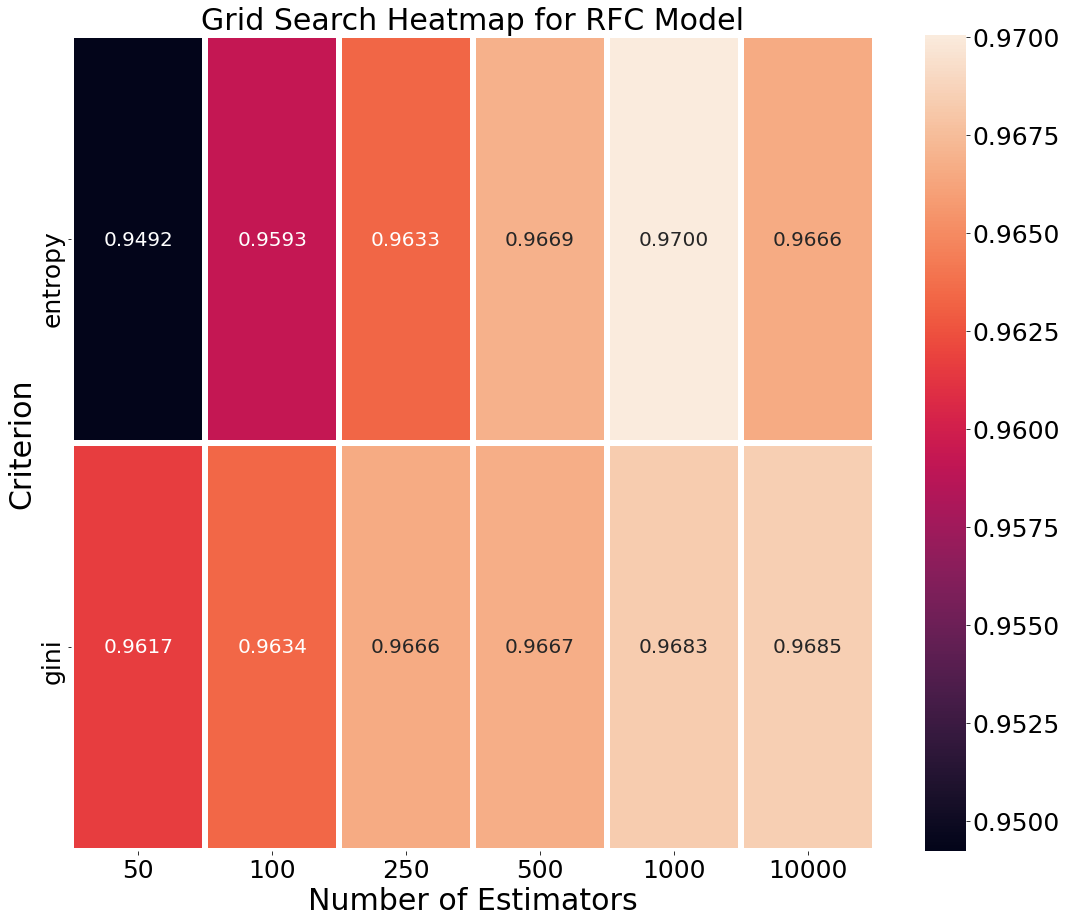

In [127]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
fig, ax = plt.subplots(figsize=(18,15));#Change the figsize to change the size
# truncated_alphas = [round(num, 5) for num in np.sort(exp_array)]
max_scores = df_rfc.groupby([
                                    'param_criterion','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
# plt.title('Hyperparameter Heatmap for LASSO Model')
ax = sns.heatmap(max_scores.mean_test_score, annot=True, fmt='2.4f',linewidths = 5)

# ax = sns.heatmap(globalWarming_df)
 
ax.set(title='Grid Search Heatmap for RFC Model',
      xlabel="Number of Estimators",
      ylabel="Criterion")

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.savefig('rfcHM1.png')

In [69]:
rfc_2 = RandomForestClassifier()
rfc_2_params  = {
    "n_estimators":[10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 12500, 15000, 20000]
}
rfc_2_tune = GridSearchCV(estimator = rfc_2, param_grid = rfc_2_params, scoring = 'f1_weighted', cv = 5, return_train_score = True, verbose = 1)
rfc_2_tune.fit(x_train_norm, y_train)
rfc_2_tune.best_params_

Fitting 5 folds for each of 13 candidates, totalling 65 fits


{'n_estimators': 1000}

In [95]:
filename = 'rfc_model_v2_47.sav'
pickle.dump(rfc_2_tune, open(filename, 'wb'))

In [27]:
# rfc_2_tune = pickle.load( open( 'rfc_model_v2_47.sav', "rb" ) )

In [96]:
rfc_2_preds = rfc_2_tune.predict(x_test_norm)

In [97]:
rfc_2_f1 = f1_score(y_test, rfc_2_preds, average = 'weighted')

In [98]:
rfc_2_f1

0.9700868150387302

In [103]:
df_rfc_2_search = pd.DataFrame(rfc_2_tune.cv_results_)

In [113]:
rfc_2_tune.best_params_

{'n_estimators': 1000}

In [105]:
#Select what columns to ommit.
# df_rfc = df_rfc_search.drop(columns=['param_metric'])
df_rfc_2 = df_rfc_2_search
df_rfc_2.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

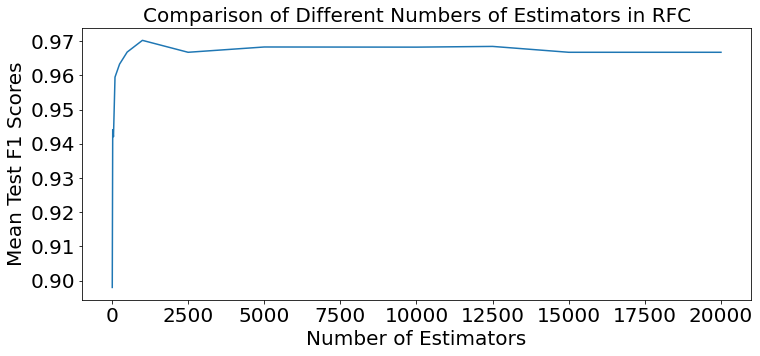

In [116]:
xVals = df_rfc_2['param_n_estimators']
yVals = df_rfc_2['mean_test_score']


# plt.yscale('log')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test F1 Scores')
plt.title('Comparison of Different Numbers of Estimators in RFC')


plt.rcParams['figure.figsize'] = [12,5]
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.plot(xVals, yVals)

plt.savefig('rfcNESTIMATORS.png')

<font color='red' size="6"> Hyperparameter Tuning for AdaBoost </font>

In [ ]:
ada_1 = AdaBoostClassifier()
ada_1_params  = {
    "n_estimators":[50, 100, 250, 500, 1000, 5000],
    "learning_rate" : [.00001, .0001, .001, .01, .1, 1]
}
ada_1_tune = GridSearchCV(estimator = ada_1, param_grid = ada_1_params, scoring = 'f1_weighted', cv = 5, return_train_score = True, verbose = 10)
ada_1_tune.fit(x_train_norm, y_train)
ada_1_tune.best_params_

In [50]:
# filename = 'ada_model_v2_45.sav'
# pickle.dump(ada_1_tune, open(filename, 'wb'))

In [37]:
ada_1_tune = pickle.load( open( 'ada_model_v2_45.sav', "rb" ) )

In [38]:
ada_preds = ada_1_tune.predict(x_test_norm)

In [39]:
ada_f1 = f1_score(y_test, ada_preds, average = 'weighted')

In [40]:
ada_f1

0.8241871736013139

In [41]:
df_ada_search = pd.DataFrame(ada_1_tune.cv_results_)

In [42]:
#Select what columns to ommit.
# df_rfc = df_rfc_search.drop(columns=['param_metric'])
df_ada = df_ada_search

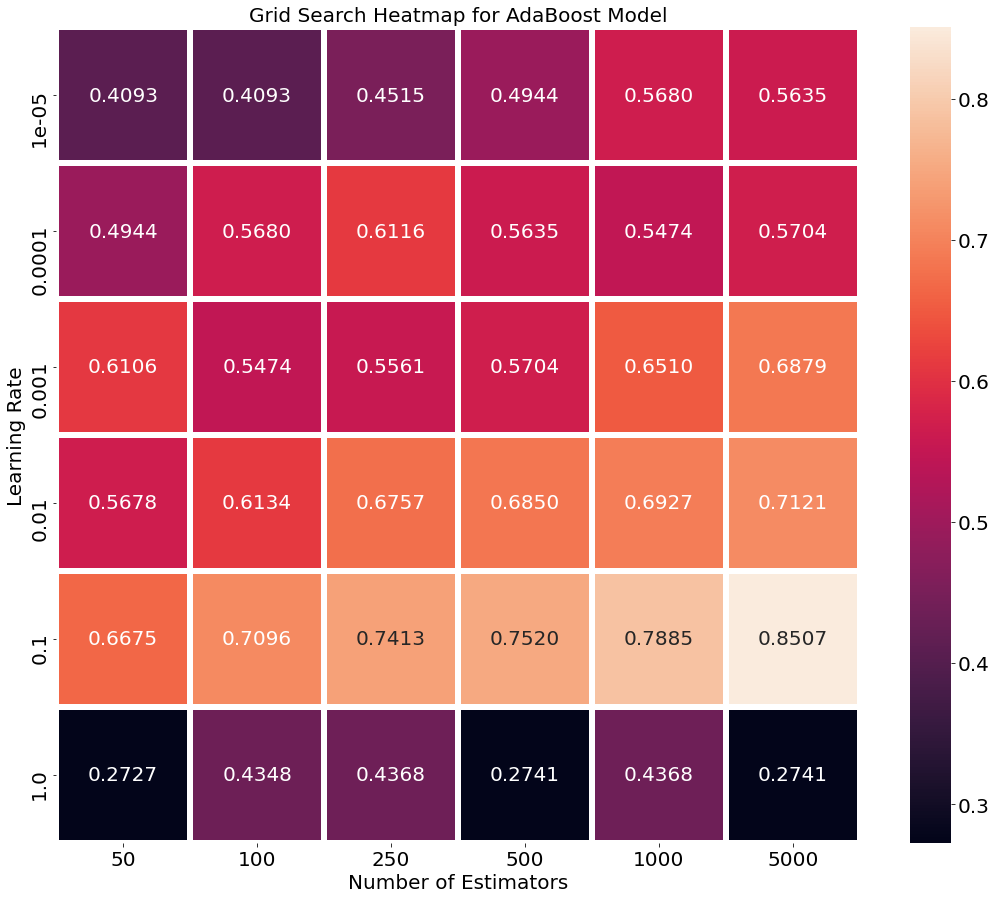

In [118]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
fig, ax = plt.subplots(figsize=(18,15));#Change the figsize to change the size
# truncated_alphas = [round(num, 5) for num in np.sort(exp_array)]
max_scores = df_ada.groupby([
                                    'param_learning_rate','param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
# plt.title('Hyperparameter Heatmap for LASSO Model')
ax = sns.heatmap(max_scores.mean_test_score, annot=True, fmt='2.4f',linewidths = 5)

# ax = sns.heatmap(globalWarming_df)
 
ax.set(title='Grid Search Heatmap for AdaBoost Model',
      xlabel="Number of Estimators",
      ylabel="Learning Rate",)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.savefig('adaHM1.png')

<font color='red' size="6"> Hyperparameter Tuning for LinearSVC </font>

In [ ]:
lsvc = LinearSVC(max_iter = 10000)
lsvc_params  = {
    "penalty":['l1', 'l2'],
    "loss" : ['hinge', 'squared_hinge'],
    "C" : [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000],
    "dual" : [False, True]
}
lsvc_tune = GridSearchCV(estimator = lsvc, param_grid = lsvc_params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
lsvc_tune.fit(x_train_norm, y_train)
lsvc_tune.best_params_

In [58]:
# filename = 'lsvc_model_v1_48.sav'
# pickle.dump(lsvc_tune, open(filename, 'wb'))

In [43]:
# lsvc_tune = pickle.load( open( 'lsvc_model_v1_48.sav', "rb" ) )

In [59]:
lsvc_tune.best_params_

{'C': 1000, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}

In [60]:
lsvc_preds = lsvc_tune.predict(x_test_norm)

In [61]:
lsvc_f1 = f1_score(y_test, lsvc_preds, average = 'weighted')

In [62]:
lsvc_f1

0.9318380625779097

In [63]:
df_lsvc_search = pd.DataFrame(lsvc_tune.cv_results_)

In [64]:
#Select what columns to ommit.
df_lsvc = df_lsvc_search.drop(columns=['param_loss', 'param_penalty'])

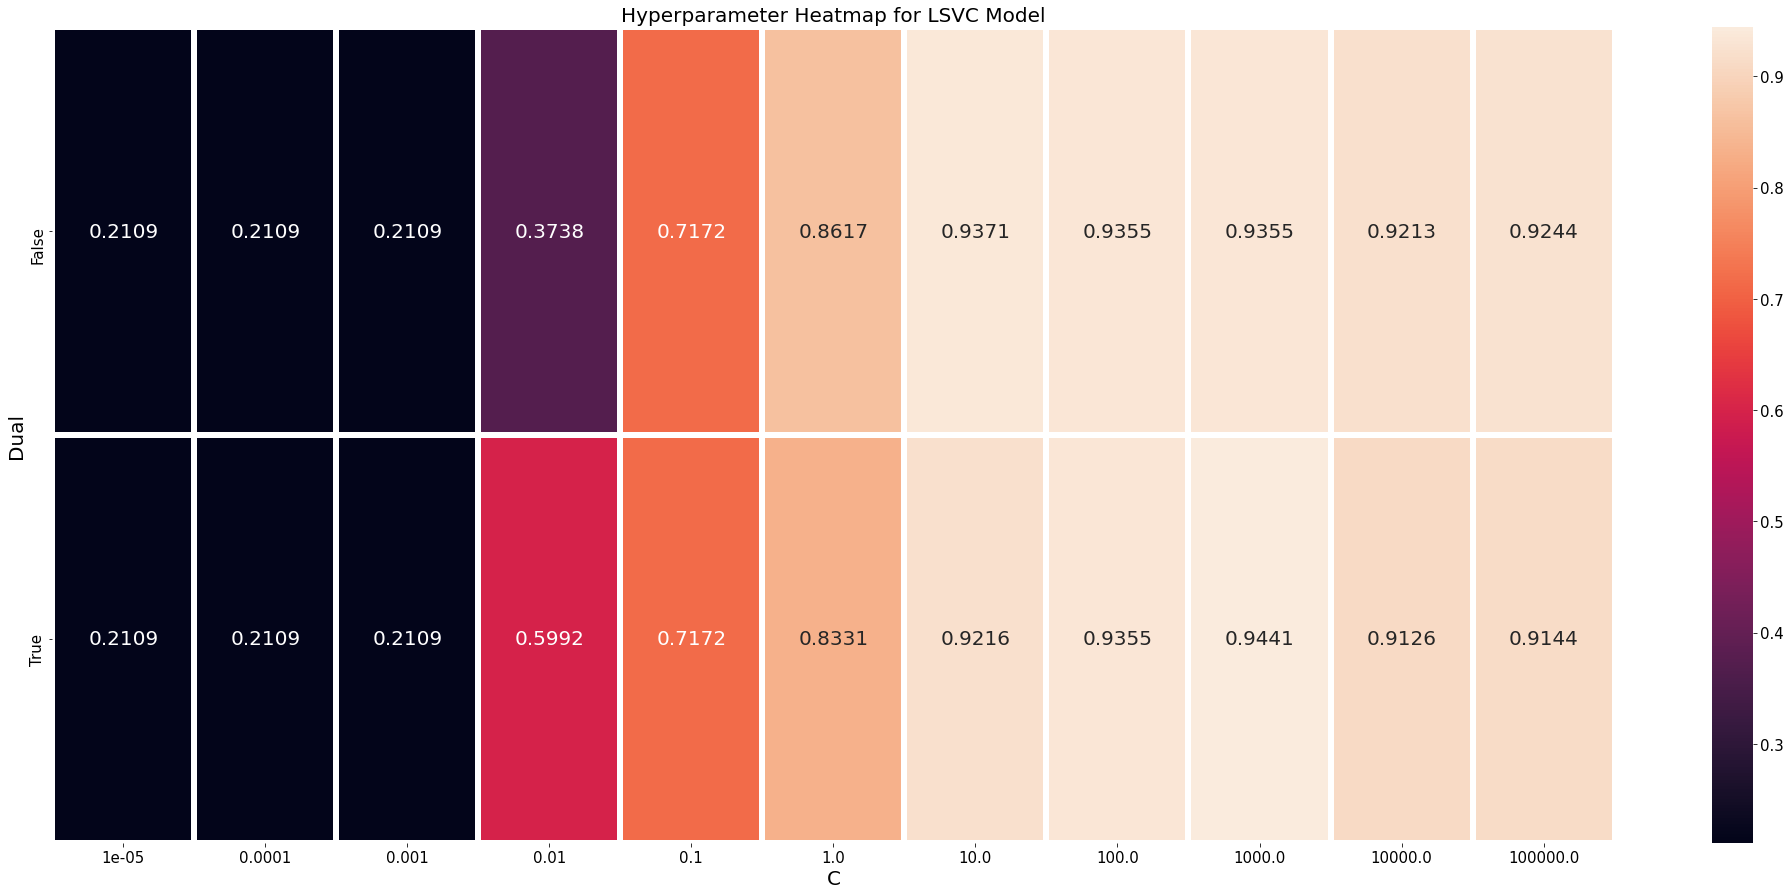

In [65]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
fig, ax = plt.subplots(figsize=(35,15));#Change the figsize to change the size
# truncated_alphas = [round(num, 5) for num in np.sort(exp_array)]
max_scores = df_lsvc.groupby([
                                    'param_dual','param_C']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
# plt.title('Hyperparameter Heatmap for LASSO Model')
ax = sns.heatmap(max_scores.mean_test_score, annot=True, fmt='2.4f',linewidths = 5)

# ax = sns.heatmap(globalWarming_df)
 
ax.set(title='Hyperparameter Heatmap for LSVC Model',
      xlabel="C",
      ylabel="Dual",)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.savefig('lsvcHM1.png')

In [31]:
df_lsvc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012773,0.000682,0.000000,0.000000,0.00001,False,"{'C': 1e-05, 'dual': False, 'loss': 'hinge', '...",NaN,NaN,NaN,...,NaN,NaN,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.012255,0.000104,0.000000,0.000000,0.00001,False,"{'C': 1e-05, 'dual': False, 'loss': 'hinge', '...",NaN,NaN,NaN,...,NaN,NaN,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.057546,0.008456,0.020107,0.003730,0.00001,False,"{'C': 1e-05, 'dual': False, 'loss': 'squared_h...",0.216856,0.208621,0.208621,...,0.210895,0.003219,33,0.209398,0.211454,0.211454,0.211454,0.210669,0.210886,0.000803
3,0.060729,0.000093,0.022022,0.000108,0.00001,False,"{'C': 1e-05, 'dual': False, 'loss': 'squared_h...",0.216856,0.208621,0.208621,...,0.210895,0.003219,33,0.209398,0.211454,0.211454,0.211454,0.210669,0.210886,0.000803
4,0.022312,0.000408,0.000000,0.000000,0.00001,True,"{'C': 1e-05, 'dual': True, 'loss': 'hinge', 'p...",NaN,NaN,NaN,...,NaN,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,3.431194,0.460649,0.012426,0.000170,100000,False,"{'C': 100000, 'dual': False, 'loss': 'squared_...",0.948053,0.930377,0.856392,...,0.909658,0.031966,19,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
84,0.022455,0.000526,0.000000,0.000000,100000,True,"{'C': 100000, 'dual': True, 'loss': 'hinge', '...",NaN,NaN,NaN,...,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,0.988545,0.012829,0.012330,0.000199,100000,True,"{'C': 100000, 'dual': True, 'loss': 'hinge', '...",0.965307,0.948363,0.930774,...,0.932550,0.023406,8,0.984926,0.956720,0.987079,0.984853,0.970289,0.976773,0.011680
86,0.022426,0.000421,0.000000,0.000000,100000,True,"{'C': 100000, 'dual': True, 'loss': 'squared_h...",NaN,NaN,NaN,...,NaN,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
lsvc_2 = LinearSVC(max_iter = 10000, loss = 'hinge', penalty = 'l2', dual = True)
lsvc_2_params  = {
    "C" : [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000]
}
lsvc_2_tune = GridSearchCV(estimator = lsvc_2, param_grid = lsvc_2_params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
lsvc_2_tune.fit(x_train_norm, y_train)
lsvc_2_tune.best_params_

In [67]:
# filename = 'lsvc_model_v2_48.sav'
# pickle.dump(lsvc_2_tune, open(filename, 'wb'))

In [22]:
# lsvc_2_tune = pickle.load( open( 'lsvc_model_v2_47.sav', "rb" ) )

In [68]:
lsvc_2_preds = lsvc_2_tune.predict(x_test_norm)

In [69]:
lsvc_2_f1 = f1_score(y_test, lsvc_2_preds, average = 'weighted')

In [70]:
lsvc_2_f1

0.9327826386471009

In [71]:
df_2_lsvc_search = pd.DataFrame(lsvc_2_tune.cv_results_)

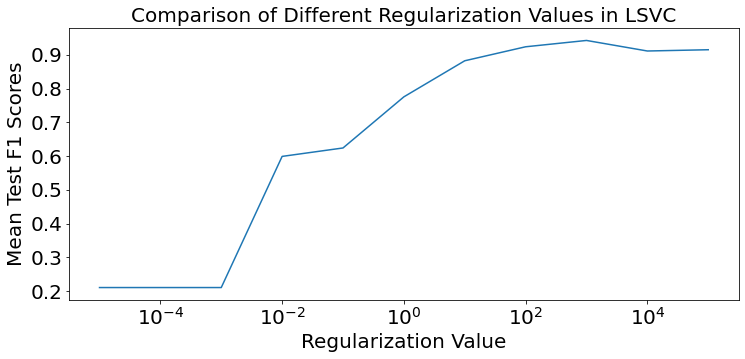

In [72]:
xVals = df_2_lsvc_search['param_C']
yVals = df_2_lsvc_search['mean_test_score']


# plt.yscale('log')

plt.xlabel('Regularization Value')
plt.ylabel('Mean Test F1 Scores')
plt.title('Comparison of Different Regularization Values in LSVC')

plt.xscale('log')
plt.rcParams['figure.figsize'] = [12,5]
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.plot(xVals, yVals)

plt.savefig('lsvcCVals.png')

<font color='red' size="6"> Hyperparameter Tuning for NuSVC </font>

In [ ]:
nsvc = NuSVC()
nsvc_params  = {
    "nu": [0.08, 0.07, 0.06, 0.05],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree" : [2, 3, 4, 5, 6],
    "gamma" : [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000],
    "coef0" : [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000]
}
nsvc_tune = GridSearchCV(estimator = nsvc, param_grid = nsvc_params, scoring = 'f1_weighted', cv = 5, return_train_score = True)
nsvc_tune.fit(x_train_norm, y_train)
nsvc_tune.best_params_

In [ ]:
filename = 'nsvc_model_v1_48_BIG.sav'
pickle.dump(nsvc_tune, open(filename, 'wb'))

In [22]:
# lsvc_tune = pickle.load( open( 'lsvc_model_v1_47.sav', "rb" ) )

In [61]:
nsvc_preds = nsvc_tune.predict(x_test_norm)

In [62]:
nsvc_f1 = f1_score(y_test, nsvc_preds, average = 'weighted')

In [63]:
nsvc_f1

0.9036993065075447

In [64]:
df_nsvc_search = pd.DataFrame(nsvc_tune.cv_results_)

In [65]:
#Select what columns to ommit.
df_nsvc = df_nsvc_search.drop(columns=['param_degree'])


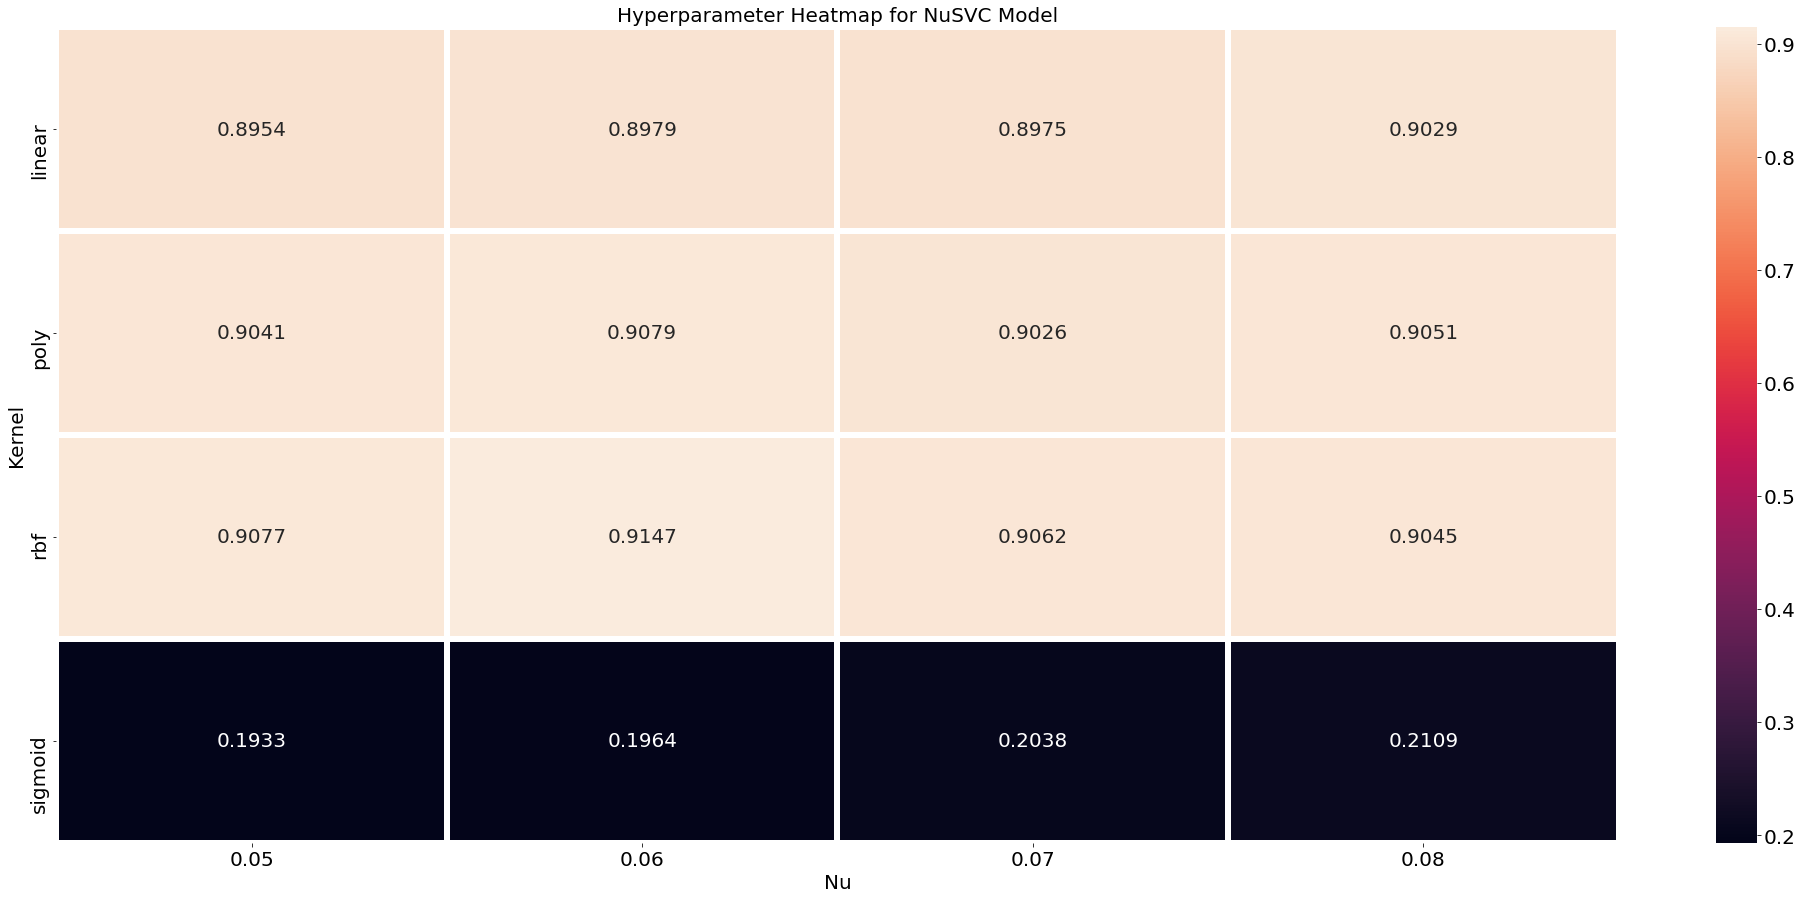

In [68]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
fig, ax = plt.subplots(figsize=(35,15));#Change the figsize to change the size
# truncated_alphas = [round(num, 5) for num in np.sort(exp_array)]
max_scores = df_nsvc.groupby([
                                    'param_kernel','param_nu']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
# plt.title('Hyperparameter Heatmap for LASSO Model')
ax = sns.heatmap(max_scores.mean_test_score, annot=True, fmt='2.4f',linewidths = 5)

# ax = sns.heatmap(globalWarming_df)
 
ax.set(title='Hyperparameter Heatmap for NuSVC Model',
      xlabel="Nu",
      ylabel="Kernel",)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=24)  # fontsize of the figure title

plt.savefig('nsvcHM1.png')